In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches # for bounding box

import torch
import torch.nn as nn
import torchvision.models.detection

from os import listdir
from os.path import isfile, join
import xml.etree.ElementTree as ET 
from PIL import Image
from tqdm import tqdm

import math
import time
import random


from pathlib import Path

C:\Users\iycsp\.conda\envs\deep-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# DATA_PATH = Path("data/")
CHECKPOINT_PATH = "checkpoints/"
# RESULTS_PATH = Path("results/")

def save_random_indices(rand_indices):
    with open(CHECKPOINT_PATH + "indices.npy", 'wb') as f:
        np.save(f, rand_indices)

def get_random_indices(is_get_new=False):
    if is_get_new:
        rand_indices = np.random.permutation(np.arange(total_len))
        return rand_indices
            
    try:
        rand_indices = np.load(CHECKPOINT_PATH + "indices.npy")
        print("[V] Load saved random indices")
        return rand_indices
    except:
        print("[E] Unable to load saved random indices")
        return None
    
def save_model_checkpoint(model, epoch, loss, prefix=""):
    cp_name = f"model_{prefix}_{epoch:02d}.pt"
    full_file_name = CHECKPOINT_PATH + cp_name
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, full_file_name)

inputs = np.load("./Datasets/processed_all_input_reduced.npy")
df = pd.read_csv("./Datasets/processed_all_output_reduced.csv")  # output

# shuffle and prepare for train test split
TRAIN_RATIO = 0.8
total_len = inputs.shape[0]
train_len = math.floor(total_len * TRAIN_RATIO)

rand_indices = get_random_indices()
train_indices, test_indices = rand_indices[:train_len], rand_indices[train_len:]
# x data
x_train, x_test = torch.Tensor(inputs[train_indices]), torch.Tensor(inputs[test_indices])
del inputs

[V] Load saved random indices


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def init_func(num_classes=20):
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
#             weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT).to(device)

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes) 
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    
    return model

In [22]:
def load_model(checkpoint_name="checkpoints/model_full_04.pt"):
    model = init_func()
    
    checkpoint = torch.load(checkpoint_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

In [23]:
model = load_model()

C:\Users\iycsp\.conda\envs\deep-cuda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\iycsp\.conda\envs\deep-cuda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
def test_and_vis_one_img(x_torch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # predict
    if x_torch.dim() == 3:
        x_torch_4d = torch.unsqueeze(x_torch, 0)
    predictions = model(x_torch_4d.to(device))
    pred = predictions[0]
    box = pred['boxes'][0].cpu().detach()
    label = pred['labels'][0].item()
    score = pred['scores'][0].item()
    
    # get data for display
    img = np.moveaxis(x_torch.numpy(), [0, 1, 2], [2, 0, 1]) * 256
    img = Image.fromarray(img.astype(np.uint8))
    x1, y1, x2, y2 = box
    
    # plot
    print(f"Label={label}\tConfidence={score}")
    fig, ax = plt.subplots()
    ax.imshow(img)
    if score > 0.4:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

Label=18	Confidence=0.5705752968788147


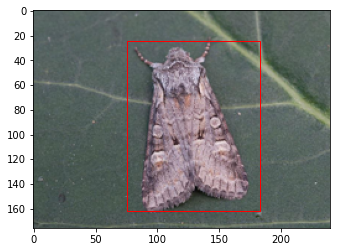

In [52]:
xx = x_test
p = test_and_vis_one_img(xx[random.randint(0, len(xx))])